In [15]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
    
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA

In [16]:
df=pd.read_csv("binance_data_2024.csv")
df.rename(columns={'Open Time':'time','Close':'close'}, inplace=True)
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df=df[['close']]
df.head()

,close
time,
2024-01-01,0.05325
2024-01-02,0.05240
2024-01-03,0.05158
2024-01-04,0.05135
2024-01-05,0.05138


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 63 entries, 2024-01-01 to 2024-03-03
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   63 non-null     float64
dtypes: float64(1)
memory usage: 1008.0 bytes


<Axes: xlabel='time'>

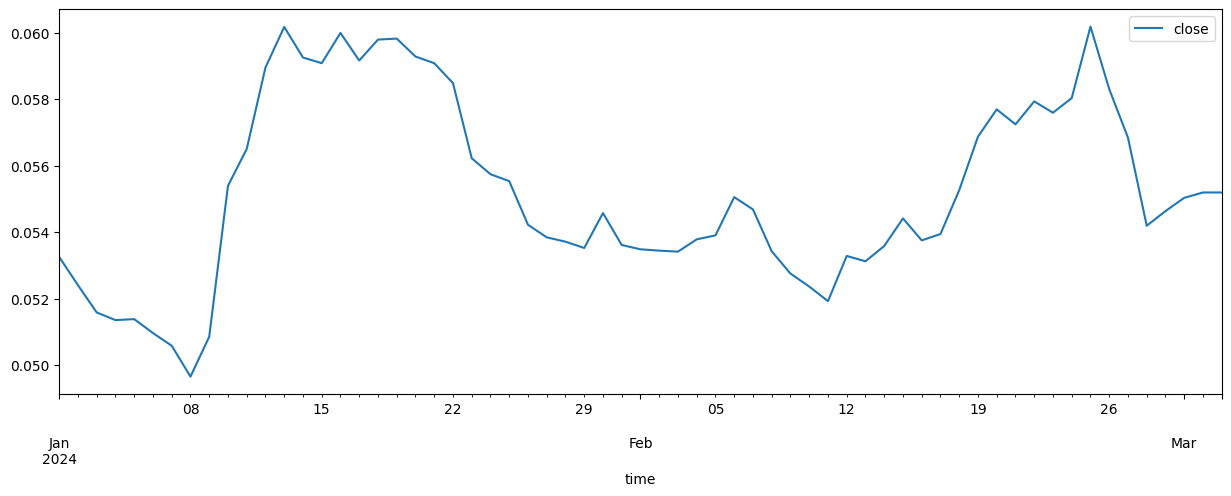

In [18]:
df.plot(figsize=(15,5))

In [20]:
TEST_SIZE = int(len(df)*0.20)
train, test = df.iloc[:-TEST_SIZE], df.iloc[-TEST_SIZE:]
x_train, x_test = np.array(range(train.shape[0])), np.array(range(train.shape[0], df.shape[0]))
train.shape, x_train.shape, test.shape, x_test.shape

((51, 1), (51,), (12, 1), (12,))

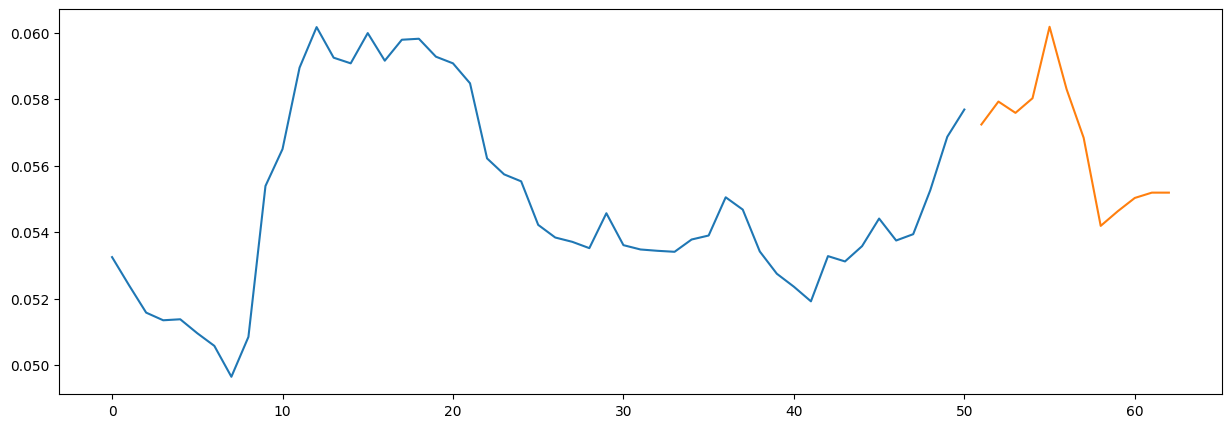

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(x_train, train)
ax.plot(x_test, test)

In [22]:
from pmdarima.arima import auto_arima

In [23]:
model = auto_arima(train, start_p=1, start_q=1,
                      test='adf',
                      max_p=5, max_q=5,
                      m=1,             
                      d=1,          
                      seasonal=False,   
                      start_P=0, 
                      D=None, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-540.112, Time=4.62 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-537.389, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-541.873, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-541.340, Time=3.61 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-539.051, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-540.019, Time=7.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-531.389, Time=5.66 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-543.718, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-541.880, Time=6.98 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-541.977, Time=4.58 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-543.169, Time=5.43 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-533.050, Time=5.03 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 43.227 seconds


In [24]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   51
Model:               SARIMAX(1, 1, 0)   Log Likelihood                 273.859
Date:                Sun, 14 Jul 2024   AIC                           -543.718
Time:                        13:58:05   BIC                           -539.894
Sample:                    01-01-2024   HQIC                          -542.262
                         - 02-20-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3565      0.195      1.828      0.068      -0.026       0.739
sigma2       1.02e-06   1.65e-07      6.184      0.000    6.96e-07    1.34e-06
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                38.71
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               0.35   Skew:                             1.22
Prob(H) (two-sided):                  0.04   Kurtosis:                         6.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [25]:
prediction, confint = model.predict(n_periods=TEST_SIZE, return_conf_int=True)

prediction

2024-02-21    0.057982
2024-02-22    0.058087
2024-02-23    0.058124
2024-02-24    0.058137
2024-02-25    0.058142
2024-02-26    0.058143
2024-02-27    0.058144
2024-02-28    0.058144
2024-02-29    0.058144
2024-03-01    0.058144
2024-03-02    0.058144
2024-03-03    0.058144
Freq: D, dtype: float64

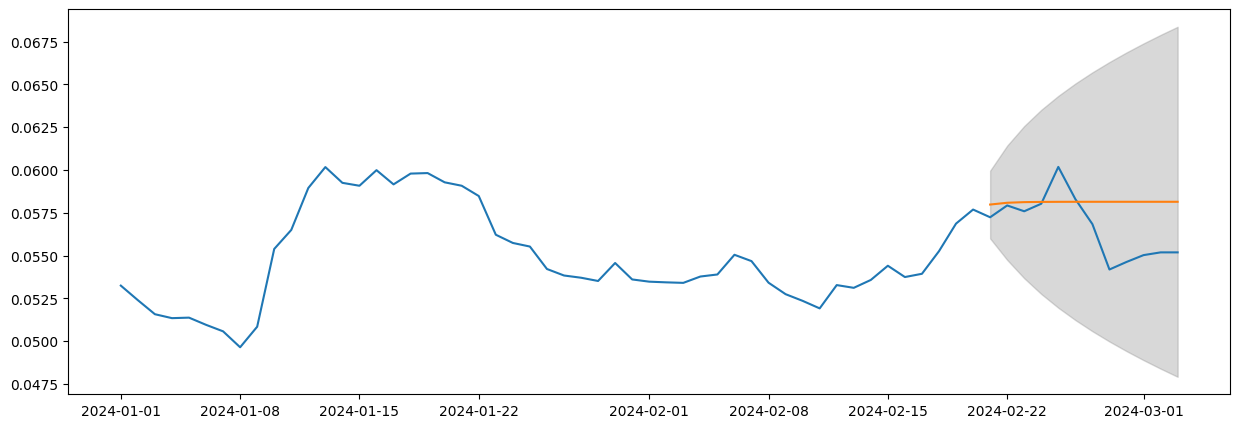

In [26]:
cf= pd.DataFrame(confint)
prediction_series = pd.Series(prediction,index=test.index)
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(df.close)
ax.plot(prediction_series)
ax.fill_between(prediction_series.index,
                cf[0],
                cf[1],color='grey',alpha=.3)

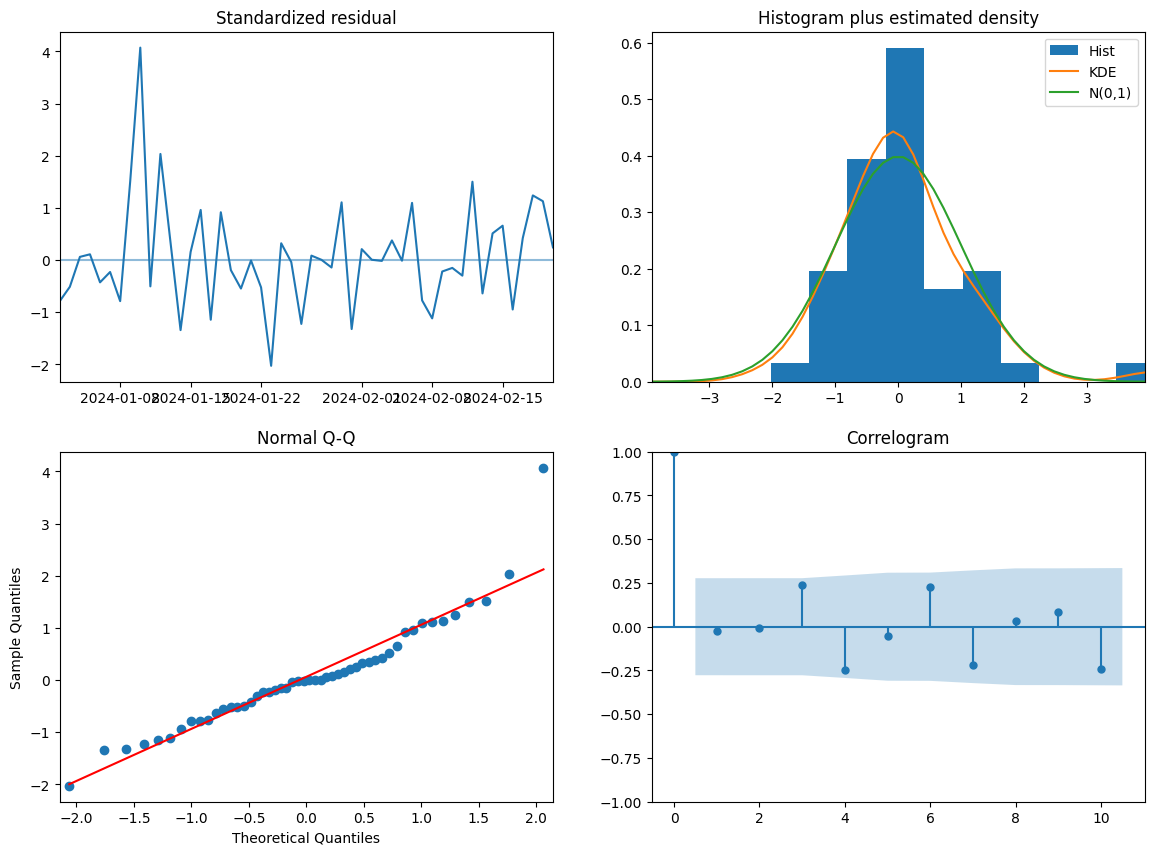

In [27]:
model.plot_diagnostics(figsize=(14,10))
plt.show()